# [Working with missing data](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html)
In this section, we will discuss missing (also referred to as NA) values in pandas.

>Note
>
>The choice of using NaN internally to denote missing data was largely for simplicity and performance reasons. Starting from pandas 1.0, some optional data types start experimenting with a native NA scalar using a mask-based approach. See here for more.

See the cookbook for some advanced strategies.

## Values considered “missing”
As data comes in many shapes and forms, pandas aims to be flexible with regard to handling missing data. While NaN is the default missing value marker for reasons of computational speed and convenience, we need to be able to easily detect this value with data of different types: floating point, integer, boolean, and general object. In many cases, however, the Python None will arise and we wish to also consider that “missing” or “not available” or “NA”.

>Note
>
>If you want to consider inf and -inf to be “NA” in computations, you can set pandas.options.mode.use_inf_as_na = True.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.DataFrame(
    np.random.randn(5, 3),
    index=["a", "c", "e", "f", "h"],
    columns=["one", "two", "three"],
)
df["four"] = "bar"
df["five"] = df["one"] > 0
df

,one,two,three,four,five
a,0.584768,0.074511,0.094157,bar,True
c,-2.122652,0.245364,1.041990,bar,False
e,-0.111247,0.083850,-0.181386,bar,False
f,0.432578,1.217946,0.370976,bar,True
h,1.538876,0.761397,-0.859864,bar,True


In [3]:
df2 = df.reindex(["a", "b", "c", "d", "e", "f", "g", "h"])
df2

,one,two,three,four,five
a,0.584768,0.074511,0.094157,bar,True
b,NaN,NaN,NaN,NaN,NaN
c,-2.122652,0.245364,1.041990,bar,False
d,NaN,NaN,NaN,NaN,NaN
e,-0.111247,0.083850,-0.181386,bar,False
f,0.432578,1.217946,0.370976,bar,True
g,NaN,NaN,NaN,NaN,NaN
h,1.538876,0.761397,-0.859864,bar,True


To make detecting missing values easier (and across different array dtypes), pandas provides the `isna()` and `notna()` functions, which are also methods on Series and DataFrame objects:

In [4]:
df2["one"]

a    0.584768
b         NaN
c   -2.122652
d         NaN
e   -0.111247
f    0.432578
g         NaN
h    1.538876
Name: one, dtype: float64

In [5]:
pd.isna(df2["one"])

a    False
b     True
c    False
d     True
e    False
f    False
g     True
h    False
Name: one, dtype: bool

In [6]:
df2["four"].notna()

a     True
b    False
c     True
d    False
e     True
f     True
g    False
h     True
Name: four, dtype: bool

In [7]:
df2.isna()

,one,two,three,four,five
a,False,False,False,False,False
b,True,True,True,True,True
c,False,False,False,False,False
d,True,True,True,True,True
e,False,False,False,False,False
f,False,False,False,False,False
g,True,True,True,True,True
h,False,False,False,False,False


>Warning
>
>One has to be mindful that in Python (and NumPy), the nan's don’t compare equal, but None's do. Note that pandas/NumPy uses the fact that np.nan != np.nan, and treats None like np.nan.

In [8]:
None == None  # noqa: E711

True

In [9]:
np.nan == np.nan

False

So as compared to above, a scalar equality comparison versus a None/np.nan doesn’t provide useful information.

In [10]:
df2["one"] == np.nan

a    False
b    False
c    False
d    False
e    False
f    False
g    False
h    False
Name: one, dtype: bool

### Integer dtypes and missing data
Because NaN is a float, a column of integers with even one missing values is cast to floating-point dtype (see Support for integer NA for more). pandas provides a nullable integer array, which can be used by explicitly requesting the dtype:

In [11]:
pd.Series([1, 2, np.nan, 4], dtype=pd.Int64Dtype())

0       1
1       2
2    <NA>
3       4
dtype: Int64

Alternatively, the string alias dtype='Int64' (note the capital "I") can be used.

See Nullable integer data type for more.

### Datetimes
For datetime64[ns] types, NaT represents missing values. This is a pseudo-native sentinel value that can be represented by NumPy in a singular dtype (datetime64[ns]). pandas objects provide compatibility between NaT and NaN.

In [12]:
df2 = df.copy()
df2["timestamp"] = pd.Timestamp("20120101")
df2

,one,two,three,four,five,timestamp
a,0.584768,0.074511,0.094157,bar,True,2012-01-01
c,-2.122652,0.245364,1.041990,bar,False,2012-01-01
e,-0.111247,0.083850,-0.181386,bar,False,2012-01-01
f,0.432578,1.217946,0.370976,bar,True,2012-01-01
h,1.538876,0.761397,-0.859864,bar,True,2012-01-01


In [13]:
df2.loc[["a", "c", "h"], ["one", "timestamp"]] = np.nan
df2

,one,two,three,four,five,timestamp
a,NaN,0.074511,0.094157,bar,True,NaT
c,NaN,0.245364,1.041990,bar,False,NaT
e,-0.111247,0.083850,-0.181386,bar,False,2012-01-01
f,0.432578,1.217946,0.370976,bar,True,2012-01-01
h,NaN,0.761397,-0.859864,bar,True,NaT


In [14]:
df2.dtypes.value_counts()

float64           3
object            1
bool              1
datetime64[ns]    1
dtype: int64

### Inserting missing data
You can insert missing values by simply assigning to containers. The actual missing value used will be chosen based on the dtype.

For example, numeric containers will always use NaN regardless of the missing value type chosen:

In [15]:
s = pd.Series([1, 2, 3])
s.loc[0] = None
s

0    NaN
1    2.0
2    3.0
dtype: float64

Likewise, datetime containers will always use NaT.

For object containers, pandas will use the value given:

In [16]:
s = pd.Series(["a", "b", "c"])
s.loc[0] = None
s.loc[1] = np.nan
s

0    None
1     NaN
2       c
dtype: object

## Calculations with missing data
Missing values propagate naturally through arithmetic operations between pandas objects.

In [17]:
a = pd.DataFrame(
    np.random.randn(5, 2),
    index=["a", "c", "e", "f", "h"],
    columns=["one", "two"],
)
a.loc['a', 'one'] = np.nan
a.loc['c', 'one'] = np.nan
a

,one,two
a,NaN,0.048483
c,NaN,-0.117829
e,-1.262481,0.687973
f,-0.763307,0.012591
h,-0.409923,-0.768517


In [18]:
b = pd.DataFrame(
    np.random.randn(5, 3),
    index=["a", "c", "e", "f", "h"],
    columns=["one", "two", "three"],
)
b.loc['a', 'one'] = np.nan
b.loc['c', 'one'] = np.nan
b.loc['h', 'one'] = np.nan
b

,one,two,three
a,NaN,-1.459846,-1.535681
c,NaN,-1.614984,0.500022
e,0.059377,0.659333,0.599466
f,0.057919,1.233096,-0.691598
h,NaN,-0.426036,0.209416


In [19]:
a + b

,one,three,two
a,NaN,NaN,-1.411363
c,NaN,NaN,-1.732813
e,-1.203104,NaN,1.347306
f,-0.705388,NaN,1.245687
h,NaN,NaN,-1.194553


The descriptive statistics and computational methods discussed in the `data structure overview` (and listed here and here) are all written to account for missing data. For example:

* When summing data, NA (missing) values will be treated as zero.

* If the data are all NA, the result will be 0.

* Cumulative methods like `cumsum()` and `cumprod()` ignore NA values by default, but preserve them in the resulting arrays. To override this behaviour and include NA values, use skipna=False.

In [20]:
df3 = b
df3

,one,two,three
a,NaN,-1.459846,-1.535681
c,NaN,-1.614984,0.500022
e,0.059377,0.659333,0.599466
f,0.057919,1.233096,-0.691598
h,NaN,-0.426036,0.209416


In [21]:
df3["one"].sum()

0.11729534068843867

In [22]:
df3.mean(1)

a   -1.497764
c   -0.557481
e    0.439392
f    0.199806
h   -0.108310
dtype: float64

In [23]:
df3.cumsum()

,one,two,three
a,NaN,-1.459846,-1.535681
c,NaN,-3.074830,-1.035660
e,0.059377,-2.415496,-0.436194
f,0.117295,-1.182400,-1.127791
h,NaN,-1.608436,-0.918375


In [24]:
df3.cumsum(skipna=False)

,one,two,three
a,NaN,-1.459846,-1.535681
c,NaN,-3.074830,-1.035660
e,NaN,-2.415496,-0.436194
f,NaN,-1.182400,-1.127791
h,NaN,-1.608436,-0.918375


## Sum/prod of empties/nans
>__Warning__: This behavior is now standard as of v0.22.0 and is consistent with the default in numpy; previously sum/prod of all-NA or empty Series/DataFrames would return NaN. See v0.22.0 whatsnew for more.

The sum of an empty or all-NA Series or column of a DataFrame is 0.

In [25]:
pd.Series([np.nan]).sum()

0.0

In [26]:
pd.Series([], dtype="float64").sum()

0.0

The product of an empty or all-NA Series or column of a DataFrame is 1.

In [27]:
pd.Series([np.nan]).prod()

1.0

In [28]:
pd.Series([], dtype="float64").prod()

1.0

## NA values in GroupBy
NA groups in GroupBy are automatically excluded. This behavior is consistent with R, for example:


In [29]:
df3

,one,two,three
a,NaN,-1.459846,-1.535681
c,NaN,-1.614984,0.500022
e,0.059377,0.659333,0.599466
f,0.057919,1.233096,-0.691598
h,NaN,-0.426036,0.209416


In [30]:
df3.groupby("one").mean()

,two,three
one,,
0.057919,1.233096,-0.691598
0.059377,0.659333,0.599466


See the groupby section here for more information.

### Cleaning / filling missing data
pandas objects are equipped with various data manipulation methods for dealing with missing data.

## Filling missing values: fillna
fillna() can “fill in” NA values with non-NA data in a couple of ways, which we illustrate:

#### Replace NA with a scalar value

In [31]:
df2

,one,two,three,four,five,timestamp
a,NaN,0.074511,0.094157,bar,True,NaT
c,NaN,0.245364,1.041990,bar,False,NaT
e,-0.111247,0.083850,-0.181386,bar,False,2012-01-01
f,0.432578,1.217946,0.370976,bar,True,2012-01-01
h,NaN,0.761397,-0.859864,bar,True,NaT


In [32]:
df2.fillna(0)

,one,two,three,four,five,timestamp
a,0.000000,0.074511,0.094157,bar,True,0
c,0.000000,0.245364,1.041990,bar,False,0
e,-0.111247,0.083850,-0.181386,bar,False,2012-01-01 00:00:00
f,0.432578,1.217946,0.370976,bar,True,2012-01-01 00:00:00
h,0.000000,0.761397,-0.859864,bar,True,0


In [33]:
df2["one"].fillna("missing")

a     missing
c     missing
e   -0.111247
f    0.432578
h     missing
Name: one, dtype: object

#### Fill gaps forward or backward

Using the same filling arguments as reindexing, we can propagate non-NA values forward or backward:

In [34]:
df3

,one,two,three
a,NaN,-1.459846,-1.535681
c,NaN,-1.614984,0.500022
e,0.059377,0.659333,0.599466
f,0.057919,1.233096,-0.691598
h,NaN,-0.426036,0.209416


In [35]:
df3.fillna(method="pad")

,one,two,three
a,NaN,-1.459846,-1.535681
c,NaN,-1.614984,0.500022
e,0.059377,0.659333,0.599466
f,0.057919,1.233096,-0.691598
h,0.057919,-0.426036,0.209416


#### Limit the amount of filling

If we only want consecutive gaps filled up to a certain number of data points, we can use the limit keyword:

In [39]:
df4 = df3
df4.loc['e', 'one'] = np.nan
df4.loc['f', 'one'] = np.nan
df4.loc['e', 'two'] = np.nan
df4.loc['f', 'two'] = np.nan
df4.loc['e', 'three'] = np.nan
df4.loc['f', 'three'] = np.nan
df4

,one,two,three
a,NaN,-1.459846,-1.535681
c,NaN,-1.614984,0.500022
e,NaN,NaN,NaN
f,NaN,NaN,NaN
h,NaN,-0.426036,0.209416


In [40]:
df4.fillna(method="pad", limit=1)

,one,two,three
a,NaN,-1.459846,-1.535681
c,NaN,-1.614984,0.500022
e,NaN,-1.614984,0.500022
f,NaN,NaN,NaN
h,NaN,-0.426036,0.209416


To remind you, these are the available filling methods:

| Method           | Action               |
|------------------|----------------------|
| pad / ffill      | Fill values forward  |
| bfill / backfill | Fill values backward |

With time series data, using pad/ffill is extremely common so that the “last known value” is available at every time point.

ffill() is equivalent to fillna(method='ffill') and bfill() is equivalent to fillna(method='bfill')

## Filling with a PandasObject
You can also fillna using a dict or Series that is alignable. The labels of the dict or index of the Series must match the columns of the frame you wish to fill. The use case of this is to fill a DataFrame with the mean of that column.

In [41]:
dff = pd.DataFrame(np.random.randn(10, 3), columns=list("ABC"))
dff.iloc[3:5, 0] = np.nan
dff.iloc[4:6, 1] = np.nan
dff.iloc[5:8, 2] = np.nan
dff

,A,B,C
0,0.225852,0.956801,0.339880
1,0.053987,-0.043022,0.836880
2,1.055457,3.020063,-1.358239
3,NaN,0.140840,0.327445
4,NaN,NaN,-0.962178
5,-1.139702,NaN,NaN
6,0.599383,0.715001,NaN
7,1.456231,-0.949984,NaN
8,-1.110785,1.088008,0.485117
9,0.083059,0.343223,-0.753260


In [42]:
dff.fillna(dff.mean())

,A,B,C
0,0.225852,0.956801,0.339880
1,0.053987,-0.043022,0.836880
2,1.055457,3.020063,-1.358239
3,0.152935,0.140840,0.327445
4,0.152935,0.658866,-0.962178
5,-1.139702,0.658866,-0.154908
6,0.599383,0.715001,-0.154908
7,1.456231,-0.949984,-0.154908
8,-1.110785,1.088008,0.485117
9,0.083059,0.343223,-0.753260


In [43]:
dff.fillna(dff.mean()["B":"C"])

,A,B,C
0,0.225852,0.956801,0.339880
1,0.053987,-0.043022,0.836880
2,1.055457,3.020063,-1.358239
3,NaN,0.140840,0.327445
4,NaN,0.658866,-0.962178
5,-1.139702,0.658866,-0.154908
6,0.599383,0.715001,-0.154908
7,1.456231,-0.949984,-0.154908
8,-1.110785,1.088008,0.485117
9,0.083059,0.343223,-0.753260


Same result as above, but is aligning the ‘fill’ value which is a Series in this case.

In [44]:
dff.where(pd.notna(dff), dff.mean(), axis="columns")

,A,B,C
0,0.225852,0.956801,0.339880
1,0.053987,-0.043022,0.836880
2,1.055457,3.020063,-1.358239
3,0.152935,0.140840,0.327445
4,0.152935,0.658866,-0.962178
5,-1.139702,0.658866,-0.154908
6,0.599383,0.715001,-0.154908
7,1.456231,-0.949984,-0.154908
8,-1.110785,1.088008,0.485117
9,0.083059,0.343223,-0.753260


## Dropping axis labels with missing data: dropna
You may wish to simply exclude labels from a data set which refer to missing data. To do this, use dropna():


In [46]:
df6 = pd.DataFrame(
    np.random.randn(5, 3),
    index=["a", "c", "e", "f", "h"],
    columns=["one", "two", "three"],
)
df6.loc['a', 'one'] = np.nan
df6.loc['c', 'one'] = np.nan
df6.loc['e', 'one'] = np.nan
df6.loc['f', 'one'] = np.nan
df6.loc['h', 'one'] = np.nan
df6

,one,two,three
a,NaN,1.666004,-1.333846
c,NaN,-0.634771,-0.294164
e,NaN,-0.668935,-0.364733
f,NaN,0.803141,-0.261786
h,NaN,0.893172,-2.164279


In [47]:
df6.dropna(axis=0)

,one,two,three


In [48]:
df6.dropna(axis=1)

,two,three
a,1.666004,-1.333846
c,-0.634771,-0.294164
e,-0.668935,-0.364733
f,0.803141,-0.261786
h,0.893172,-2.164279


In [49]:
df6["one"].dropna()

Series([], Name: one, dtype: float64)

An equivalent dropna() is available for Series. DataFrame.dropna has considerably more options than Series.dropna, which can be examined in the API.

## Interpolation
Both Series and DataFrame objects have interpolate() that, by default, performs linear interpolation at missing data points.

In [73]:
n_samples = 100
columns = ['Value']
ts = pd.DataFrame(pd.Series(np.random.uniform(size=n_samples),
                            index=pd.date_range("2000-01-31",
                                                freq="M",
                                                periods=n_samples)),
                  columns=columns
                 )
ts.rename(index={0:'DateTime'}, inplace=True)
ts

,Value
2000-01-31,0.563583
2000-02-29,0.327310
2000-03-31,0.598116
2000-04-30,0.302839
2000-05-31,0.104268
...,...
2007-12-31,0.442684
2008-01-31,0.262409
2008-02-29,0.452674
2008-03-31,0.255611


In [57]:
ts.count()

66

<AxesSubplot:>

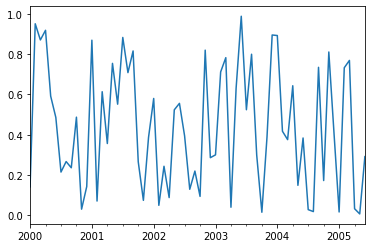

In [58]:
ts.plot()

In [61]: ts
Out[61]: 
2000-01-31    0.469112
2000-02-29         NaN
2000-03-31         NaN
2000-04-28         NaN
2000-05-31         NaN
                ...   
2007-12-31   -6.950267
2008-01-31   -7.904475
2008-02-29   -6.441779
2008-03-31   -8.184940
2008-04-30   -9.011531
Freq: BM, Length: 100, dtype: float64

In [62]: ts.count()
Out[62]: 66

In [63]: ts.plot()
Out[63]: <AxesSubplot:>
../_images/series_before_interpolate.png
In [64]: ts.interpolate()
Out[64]: 
2000-01-31    0.469112
2000-02-29    0.434469
2000-03-31    0.399826
2000-04-28    0.365184
2000-05-31    0.330541
                ...   
2007-12-31   -6.950267
2008-01-31   -7.904475
2008-02-29   -6.441779
2008-03-31   -8.184940
2008-04-30   -9.011531
Freq: BM, Length: 100, dtype: float64

In [65]: ts.interpolate().count()
Out[65]: 100

In [66]: ts.interpolate().plot()
Out[66]: <AxesSubplot:>
../_images/series_interpolate.png
Index aware interpolation is available via the method keyword:

In [67]: ts2
Out[67]: 
2000-01-31    0.469112
2000-02-29         NaN
2002-07-31   -5.785037
2005-01-31         NaN
2008-04-30   -9.011531
dtype: float64

In [68]: ts2.interpolate()
Out[68]: 
2000-01-31    0.469112
2000-02-29   -2.657962
2002-07-31   -5.785037
2005-01-31   -7.398284
2008-04-30   -9.011531
dtype: float64

In [69]: ts2.interpolate(method="time")
Out[69]: 
2000-01-31    0.469112
2000-02-29    0.270241
2002-07-31   -5.785037
2005-01-31   -7.190866
2008-04-30   -9.011531
dtype: float64
For a floating-point index, use method='values':

In [70]: ser
Out[70]: 
0.0      0.0
1.0      NaN
10.0    10.0
dtype: float64

In [71]: ser.interpolate()
Out[71]: 
0.0      0.0
1.0      5.0
10.0    10.0
dtype: float64

In [72]: ser.interpolate(method="values")
Out[72]: 
0.0      0.0
1.0      1.0
10.0    10.0
dtype: float64
You can also interpolate with a DataFrame:

In [73]: df = pd.DataFrame(
   ....:     {
   ....:         "A": [1, 2.1, np.nan, 4.7, 5.6, 6.8],
   ....:         "B": [0.25, np.nan, np.nan, 4, 12.2, 14.4],
   ....:     }
   ....: )
   ....: 

In [74]: df
Out[74]: 
     A      B
0  1.0   0.25
1  2.1    NaN
2  NaN    NaN
3  4.7   4.00
4  5.6  12.20
5  6.8  14.40

In [75]: df.interpolate()
Out[75]: 
     A      B
0  1.0   0.25
1  2.1   1.50
2  3.4   2.75
3  4.7   4.00
4  5.6  12.20
5  6.8  14.40
The method argument gives access to fancier interpolation methods. If you have scipy installed, you can pass the name of a 1-d interpolation routine to method. You’ll want to consult the full scipy interpolation documentation and reference guide for details. The appropriate interpolation method will depend on the type of data you are working with.

If you are dealing with a time series that is growing at an increasing rate, method='quadratic' may be appropriate.

If you have values approximating a cumulative distribution function, then method='pchip' should work well.

To fill missing values with goal of smooth plotting, consider method='akima'.

Warning

These methods require scipy.

In [76]: df.interpolate(method="barycentric")
Out[76]: 
      A       B
0  1.00   0.250
1  2.10  -7.660
2  3.53  -4.515
3  4.70   4.000
4  5.60  12.200
5  6.80  14.400

In [77]: df.interpolate(method="pchip")
Out[77]: 
         A          B
0  1.00000   0.250000
1  2.10000   0.672808
2  3.43454   1.928950
3  4.70000   4.000000
4  5.60000  12.200000
5  6.80000  14.400000

In [78]: df.interpolate(method="akima")
Out[78]: 
          A          B
0  1.000000   0.250000
1  2.100000  -0.873316
2  3.406667   0.320034
3  4.700000   4.000000
4  5.600000  12.200000
5  6.800000  14.400000
When interpolating via a polynomial or spline approximation, you must also specify the degree or order of the approximation:

In [79]: df.interpolate(method="spline", order=2)
Out[79]: 
          A          B
0  1.000000   0.250000
1  2.100000  -0.428598
2  3.404545   1.206900
3  4.700000   4.000000
4  5.600000  12.200000
5  6.800000  14.400000

In [80]: df.interpolate(method="polynomial", order=2)
Out[80]: 
          A          B
0  1.000000   0.250000
1  2.100000  -2.703846
2  3.451351  -1.453846
3  4.700000   4.000000
4  5.600000  12.200000
5  6.800000  14.400000
Compare several methods:

In [81]: np.random.seed(2)

In [82]: ser = pd.Series(np.arange(1, 10.1, 0.25) ** 2 + np.random.randn(37))

In [83]: missing = np.array([4, 13, 14, 15, 16, 17, 18, 20, 29])

In [84]: ser[missing] = np.nan

In [85]: methods = ["linear", "quadratic", "cubic"]

In [86]: df = pd.DataFrame({m: ser.interpolate(method=m) for m in methods})

In [87]: df.plot()
Out[87]: <AxesSubplot:>
../_images/compare_interpolations.png
Another use case is interpolation at new values. Suppose you have 100 observations from some distribution. And let’s suppose that you’re particularly interested in what’s happening around the middle. You can mix pandas’ reindex and interpolate methods to interpolate at the new values.

In [88]: ser = pd.Series(np.sort(np.random.uniform(size=100)))

# interpolate at new_index
In [89]: new_index = ser.index.union(pd.Index([49.25, 49.5, 49.75, 50.25, 50.5, 50.75]))

In [90]: interp_s = ser.reindex(new_index).interpolate(method="pchip")

In [91]: interp_s[49:51]
Out[91]: 
49.00    0.471410
49.25    0.476841
49.50    0.481780
49.75    0.485998
50.00    0.489266
50.25    0.491814
50.50    0.493995
50.75    0.495763
51.00    0.497074
dtype: float64
Interpolation limits
Like other pandas fill methods, interpolate() accepts a limit keyword argument. Use this argument to limit the number of consecutive NaN values filled since the last valid observation:

In [92]: ser = pd.Series([np.nan, np.nan, 5, np.nan, np.nan, np.nan, 13, np.nan, np.nan])

In [93]: ser
Out[93]: 
0     NaN
1     NaN
2     5.0
3     NaN
4     NaN
5     NaN
6    13.0
7     NaN
8     NaN
dtype: float64

# fill all consecutive values in a forward direction
In [94]: ser.interpolate()
Out[94]: 
0     NaN
1     NaN
2     5.0
3     7.0
4     9.0
5    11.0
6    13.0
7    13.0
8    13.0
dtype: float64

# fill one consecutive value in a forward direction
In [95]: ser.interpolate(limit=1)
Out[95]: 
0     NaN
1     NaN
2     5.0
3     7.0
4     NaN
5     NaN
6    13.0
7    13.0
8     NaN
dtype: float64
By default, NaN values are filled in a forward direction. Use limit_direction parameter to fill backward or from both directions.

# fill one consecutive value backwards
In [96]: ser.interpolate(limit=1, limit_direction="backward")
Out[96]: 
0     NaN
1     5.0
2     5.0
3     NaN
4     NaN
5    11.0
6    13.0
7     NaN
8     NaN
dtype: float64

# fill one consecutive value in both directions
In [97]: ser.interpolate(limit=1, limit_direction="both")
Out[97]: 
0     NaN
1     5.0
2     5.0
3     7.0
4     NaN
5    11.0
6    13.0
7    13.0
8     NaN
dtype: float64

# fill all consecutive values in both directions
In [98]: ser.interpolate(limit_direction="both")
Out[98]: 
0     5.0
1     5.0
2     5.0
3     7.0
4     9.0
5    11.0
6    13.0
7    13.0
8    13.0
dtype: float64
By default, NaN values are filled whether they are inside (surrounded by) existing valid values, or outside existing valid values. The limit_area parameter restricts filling to either inside or outside values.

# fill one consecutive inside value in both directions
In [99]: ser.interpolate(limit_direction="both", limit_area="inside", limit=1)
Out[99]: 
0     NaN
1     NaN
2     5.0
3     7.0
4     NaN
5    11.0
6    13.0
7     NaN
8     NaN
dtype: float64

# fill all consecutive outside values backward
In [100]: ser.interpolate(limit_direction="backward", limit_area="outside")
Out[100]: 
0     5.0
1     5.0
2     5.0
3     NaN
4     NaN
5     NaN
6    13.0
7     NaN
8     NaN
dtype: float64

# fill all consecutive outside values in both directions
In [101]: ser.interpolate(limit_direction="both", limit_area="outside")
Out[101]: 
0     5.0
1     5.0
2     5.0
3     NaN
4     NaN
5     NaN
6    13.0
7    13.0
8    13.0
dtype: float64
Replacing generic values
Often times we want to replace arbitrary values with other values.

replace() in Series and replace() in DataFrame provides an efficient yet flexible way to perform such replacements.

For a Series, you can replace a single value or a list of values by another value:

In [102]: ser = pd.Series([0.0, 1.0, 2.0, 3.0, 4.0])

In [103]: ser.replace(0, 5)
Out[103]: 
0    5.0
1    1.0
2    2.0
3    3.0
4    4.0
dtype: float64
You can replace a list of values by a list of other values:

In [104]: ser.replace([0, 1, 2, 3, 4], [4, 3, 2, 1, 0])
Out[104]: 
0    4.0
1    3.0
2    2.0
3    1.0
4    0.0
dtype: float64
You can also specify a mapping dict:

In [105]: ser.replace({0: 10, 1: 100})
Out[105]: 
0     10.0
1    100.0
2      2.0
3      3.0
4      4.0
dtype: float64
For a DataFrame, you can specify individual values by column:

In [106]: df = pd.DataFrame({"a": [0, 1, 2, 3, 4], "b": [5, 6, 7, 8, 9]})

In [107]: df.replace({"a": 0, "b": 5}, 100)
Out[107]: 
     a    b
0  100  100
1    1    6
2    2    7
3    3    8
4    4    9
Instead of replacing with specified values, you can treat all given values as missing and interpolate over them:

In [108]: ser.replace([1, 2, 3], method="pad")
Out[108]: 
0    0.0
1    0.0
2    0.0
3    0.0
4    4.0
dtype: float64
String/regular expression replacement
Note

Python strings prefixed with the r character such as r'hello world' are so-called “raw” strings. They have different semantics regarding backslashes than strings without this prefix. Backslashes in raw strings will be interpreted as an escaped backslash, e.g., r'\' == '\\'. You should read about them if this is unclear.

Replace the ‘.’ with NaN (str -> str):

In [109]: d = {"a": list(range(4)), "b": list("ab.."), "c": ["a", "b", np.nan, "d"]}

In [110]: df = pd.DataFrame(d)

In [111]: df.replace(".", np.nan)
Out[111]: 
   a    b    c
0  0    a    a
1  1    b    b
2  2  NaN  NaN
3  3  NaN    d
Now do it with a regular expression that removes surrounding whitespace (regex -> regex):

In [112]: df.replace(r"\s*\.\s*", np.nan, regex=True)
Out[112]: 
   a    b    c
0  0    a    a
1  1    b    b
2  2  NaN  NaN
3  3  NaN    d
Replace a few different values (list -> list):

In [113]: df.replace(["a", "."], ["b", np.nan])
Out[113]: 
   a    b    c
0  0    b    b
1  1    b    b
2  2  NaN  NaN
3  3  NaN    d
list of regex -> list of regex:

In [114]: df.replace([r"\.", r"(a)"], ["dot", r"\1stuff"], regex=True)
Out[114]: 
   a       b       c
0  0  astuff  astuff
1  1       b       b
2  2     dot     NaN
3  3     dot       d
Only search in column 'b' (dict -> dict):

In [115]: df.replace({"b": "."}, {"b": np.nan})
Out[115]: 
   a    b    c
0  0    a    a
1  1    b    b
2  2  NaN  NaN
3  3  NaN    d
Same as the previous example, but use a regular expression for searching instead (dict of regex -> dict):

In [116]: df.replace({"b": r"\s*\.\s*"}, {"b": np.nan}, regex=True)
Out[116]: 
   a    b    c
0  0    a    a
1  1    b    b
2  2  NaN  NaN
3  3  NaN    d
You can pass nested dictionaries of regular expressions that use regex=True:

In [117]: df.replace({"b": {"b": r""}}, regex=True)
Out[117]: 
   a  b    c
0  0  a    a
1  1       b
2  2  .  NaN
3  3  .    d
Alternatively, you can pass the nested dictionary like so:

In [118]: df.replace(regex={"b": {r"\s*\.\s*": np.nan}})
Out[118]: 
   a    b    c
0  0    a    a
1  1    b    b
2  2  NaN  NaN
3  3  NaN    d
You can also use the group of a regular expression match when replacing (dict of regex -> dict of regex), this works for lists as well.

In [119]: df.replace({"b": r"\s*(\.)\s*"}, {"b": r"\1ty"}, regex=True)
Out[119]: 
   a    b    c
0  0    a    a
1  1    b    b
2  2  .ty  NaN
3  3  .ty    d
You can pass a list of regular expressions, of which those that match will be replaced with a scalar (list of regex -> regex).

In [120]: df.replace([r"\s*\.\s*", r"a|b"], np.nan, regex=True)
Out[120]: 
   a   b    c
0  0 NaN  NaN
1  1 NaN  NaN
2  2 NaN  NaN
3  3 NaN    d
All of the regular expression examples can also be passed with the to_replace argument as the regex argument. In this case the value argument must be passed explicitly by name or regex must be a nested dictionary. The previous example, in this case, would then be:

In [121]: df.replace(regex=[r"\s*\.\s*", r"a|b"], value=np.nan)
Out[121]: 
   a   b    c
0  0 NaN  NaN
1  1 NaN  NaN
2  2 NaN  NaN
3  3 NaN    d
This can be convenient if you do not want to pass regex=True every time you want to use a regular expression.

Note

Anywhere in the above replace examples that you see a regular expression a compiled regular expression is valid as well.

Numeric replacement
replace() is similar to fillna().

In [122]: df = pd.DataFrame(np.random.randn(10, 2))

In [123]: df[np.random.rand(df.shape[0]) > 0.5] = 1.5

In [124]: df.replace(1.5, np.nan)
Out[124]: 
          0         1
0 -0.844214 -1.021415
1  0.432396 -0.323580
2  0.423825  0.799180
3  1.262614  0.751965
4       NaN       NaN
5       NaN       NaN
6 -0.498174 -1.060799
7  0.591667 -0.183257
8  1.019855 -1.482465
9       NaN       NaN
Replacing more than one value is possible by passing a list.

In [125]: df00 = df.iloc[0, 0]

In [126]: df.replace([1.5, df00], [np.nan, "a"])
Out[126]: 
          0         1
0         a -1.021415
1  0.432396  -0.32358
2  0.423825   0.79918
3  1.262614  0.751965
4       NaN       NaN
5       NaN       NaN
6 -0.498174 -1.060799
7  0.591667 -0.183257
8  1.019855 -1.482465
9       NaN       NaN

In [127]: df[1].dtype
Out[127]: dtype('float64')
You can also operate on the DataFrame in place:

In [128]: df.replace(1.5, np.nan, inplace=True)
Missing data casting rules and indexing
While pandas supports storing arrays of integer and boolean type, these types are not capable of storing missing data. Until we can switch to using a native NA type in NumPy, we’ve established some “casting rules”. When a reindexing operation introduces missing data, the Series will be cast according to the rules introduced in the table below.

data type

Cast to

integer

float

boolean

object

float

no cast

object

no cast

For example:

In [129]: s = pd.Series(np.random.randn(5), index=[0, 2, 4, 6, 7])

In [130]: s > 0
Out[130]: 
0    True
2    True
4    True
6    True
7    True
dtype: bool

In [131]: (s > 0).dtype
Out[131]: dtype('bool')

In [132]: crit = (s > 0).reindex(list(range(8)))

In [133]: crit
Out[133]: 
0    True
1     NaN
2    True
3     NaN
4    True
5     NaN
6    True
7    True
dtype: object

In [134]: crit.dtype
Out[134]: dtype('O')
Ordinarily NumPy will complain if you try to use an object array (even if it contains boolean values) instead of a boolean array to get or set values from an ndarray (e.g. selecting values based on some criteria). If a boolean vector contains NAs, an exception will be generated:

In [135]: reindexed = s.reindex(list(range(8))).fillna(0)

In [136]: reindexed[crit]
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-136-0dac417a4890> in <module>
----> 1 reindexed[crit]

/pandas/pandas/core/series.py in __getitem__(self, key)
    870             key = list(key)
    871 
--> 872         if com.is_bool_indexer(key):
    873             key = check_bool_indexer(self.index, key)
    874             key = np.asarray(key, dtype=bool)

/pandas/pandas/core/common.py in is_bool_indexer(key)
    112                     # Don't raise on e.g. ["A", "B", np.nan], see
    113                     #  test_loc_getitem_list_of_labels_categoricalindex_with_na
--> 114                     raise ValueError(na_msg)
    115                 return False
    116             return True

ValueError: Cannot mask with non-boolean array containing NA / NaN values
However, these can be filled in using fillna() and it will work fine:

In [137]: reindexed[crit.fillna(False)]
Out[137]: 
0    0.126504
2    0.696198
4    0.697416
6    0.601516
7    0.003659
dtype: float64

In [138]: reindexed[crit.fillna(True)]
Out[138]: 
0    0.126504
1    0.000000
2    0.696198
3    0.000000
4    0.697416
5    0.000000
6    0.601516
7    0.003659
dtype: float64
pandas provides a nullable integer dtype, but you must explicitly request it when creating the series or column. Notice that we use a capital “I” in the dtype="Int64".

In [139]: s = pd.Series([0, 1, np.nan, 3, 4], dtype="Int64")

In [140]: s
Out[140]: 
0       0
1       1
2    <NA>
3       3
4       4
dtype: Int64
See Nullable integer data type for more.

Experimental NA scalar to denote missing values
Warning

Experimental: the behaviour of pd.NA can still change without warning.

New in version 1.0.0.

Starting from pandas 1.0, an experimental pd.NA value (singleton) is available to represent scalar missing values. At this moment, it is used in the nullable integer, boolean and dedicated string data types as the missing value indicator.

The goal of pd.NA is provide a “missing” indicator that can be used consistently across data types (instead of np.nan, None or pd.NaT depending on the data type).

For example, when having missing values in a Series with the nullable integer dtype, it will use pd.NA:

In [141]: s = pd.Series([1, 2, None], dtype="Int64")

In [142]: s
Out[142]: 
0       1
1       2
2    <NA>
dtype: Int64

In [143]: s[2]
Out[143]: <NA>

In [144]: s[2] is pd.NA
Out[144]: True
Currently, pandas does not yet use those data types by default (when creating a DataFrame or Series, or when reading in data), so you need to specify the dtype explicitly. An easy way to convert to those dtypes is explained here.

Propagation in arithmetic and comparison operations
In general, missing values propagate in operations involving pd.NA. When one of the operands is unknown, the outcome of the operation is also unknown.

For example, pd.NA propagates in arithmetic operations, similarly to np.nan:

In [145]: pd.NA + 1
Out[145]: <NA>

In [146]: "a" * pd.NA
Out[146]: <NA>
There are a few special cases when the result is known, even when one of the operands is NA.

In [147]: pd.NA ** 0
Out[147]: 1

In [148]: 1 ** pd.NA
Out[148]: 1
In equality and comparison operations, pd.NA also propagates. This deviates from the behaviour of np.nan, where comparisons with np.nan always return False.

In [149]: pd.NA == 1
Out[149]: <NA>

In [150]: pd.NA == pd.NA
Out[150]: <NA>

In [151]: pd.NA < 2.5
Out[151]: <NA>
To check if a value is equal to pd.NA, the isna() function can be used:

In [152]: pd.isna(pd.NA)
Out[152]: True
An exception on this basic propagation rule are reductions (such as the mean or the minimum), where pandas defaults to skipping missing values. See above for more.

Logical operations
For logical operations, pd.NA follows the rules of the three-valued logic (or Kleene logic, similarly to R, SQL and Julia). This logic means to only propagate missing values when it is logically required.

For example, for the logical “or” operation (|), if one of the operands is True, we already know the result will be True, regardless of the other value (so regardless the missing value would be True or False). In this case, pd.NA does not propagate:

In [153]: True | False
Out[153]: True

In [154]: True | pd.NA
Out[154]: True

In [155]: pd.NA | True
Out[155]: True
On the other hand, if one of the operands is False, the result depends on the value of the other operand. Therefore, in this case pd.NA propagates:

In [156]: False | True
Out[156]: True

In [157]: False | False
Out[157]: False

In [158]: False | pd.NA
Out[158]: <NA>
The behaviour of the logical “and” operation (&) can be derived using similar logic (where now pd.NA will not propagate if one of the operands is already False):

In [159]: False & True
Out[159]: False

In [160]: False & False
Out[160]: False

In [161]: False & pd.NA
Out[161]: False
In [162]: True & True
Out[162]: True

In [163]: True & False
Out[163]: False

In [164]: True & pd.NA
Out[164]: <NA>
NA in a boolean context
Since the actual value of an NA is unknown, it is ambiguous to convert NA to a boolean value. The following raises an error:

In [165]: bool(pd.NA)
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-165-5477a57d5abb> in <module>
----> 1 bool(pd.NA)

/pandas/pandas/_libs/missing.pyx in pandas._libs.missing.NAType.__bool__()

TypeError: boolean value of NA is ambiguous
This also means that pd.NA cannot be used in a context where it is evaluated to a boolean, such as if condition: ... where condition can potentially be pd.NA. In such cases, isna() can be used to check for pd.NA or condition being pd.NA can be avoided, for example by filling missing values beforehand.

A similar situation occurs when using Series or DataFrame objects in if statements, see Using if/truth statements with pandas.

NumPy ufuncs
pandas.NA implements NumPy’s __array_ufunc__ protocol. Most ufuncs work with NA, and generally return NA:

In [166]: np.log(pd.NA)
Out[166]: <NA>

In [167]: np.add(pd.NA, 1)
Out[167]: <NA>
Warning

Currently, ufuncs involving an ndarray and NA will return an object-dtype filled with NA values.

In [168]: a = np.array([1, 2, 3])

In [169]: np.greater(a, pd.NA)
Out[169]: array([<NA>, <NA>, <NA>], dtype=object)
The return type here may change to return a different array type in the future.

See DataFrame interoperability with NumPy functions for more on ufuncs.

Conversion
If you have a DataFrame or Series using traditional types that have missing data represented using np.nan, there are convenience methods convert_dtypes() in Series and convert_dtypes() in DataFrame that can convert data to use the newer dtypes for integers, strings and booleans listed here. This is especially helpful after reading in data sets when letting the readers such as read_csv() and read_excel() infer default dtypes.

In this example, while the dtypes of all columns are changed, we show the results for the first 10 columns.

In [170]: bb = pd.read_csv("data/baseball.csv", index_col="id")

In [171]: bb[bb.columns[:10]].dtypes
Out[171]: 
player    object
year       int64
stint      int64
team      object
lg        object
g          int64
ab         int64
r          int64
h          int64
X2b        int64
dtype: object
In [172]: bbn = bb.convert_dtypes()

In [173]: bbn[bbn.columns[:10]].dtypes
Out[173]: 
player    string
year       Int64
stint      Int64
team      string
lg        string
g          Int64
ab         Int64
r          Int64
h          Int64
X2b        Int64
dtype: object